In [1]:
import os
import cv2
import numpy as np
import supervision as sv

import torch
import torchvision

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

import config.config as cfg
import params
import utils

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
# Building GroundingDINO inference model
grounding_dino_model = Model(
    model_config_path=cfg.GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=cfg.GROUNDING_DINO_CHECKPOINT_PATH,
)

# Building SAM Model and SAM Predictor
sam = sam_model_registry[cfg.SAM_ENCODER_VERSION](checkpoint=cfg.SAM_CHECKPOINT_PATH)
sam.to(device=params.DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


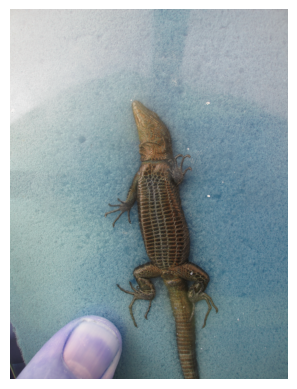

In [3]:
# Define the source image path
SOURCE_IMAGE_PATH = "example_images/IMG_0858.jpg"

# Load and display the source image
image = cv2.imread(SOURCE_IMAGE_PATH)
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
# Detect objects using GroundingDINO
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=params.CLASSES,
    box_threshold=params.BOX_THRESHOLD,
    text_threshold=params.TEXT_THRESHOLD,
)

# Annotate image with bounding boxes and labels
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
labels = [
    f"{params.CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _ in detections
]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels
)

# Save the annotated image with bounding boxes
cv2.imwrite("example_image/groundingdino_annotated_image.jpg", annotated_frame)

False

In [5]:
# Apply Non-Maximum Suppression (NMS) to filter detections
print(f"Before NMS: {len(detections.xyxy)} boxes")
nms_idx = (
    torchvision.ops.nms(
        torch.from_numpy(detections.xyxy),
        torch.from_numpy(detections.confidence),
        params.NMS_THRESHOLD,
    )
    .numpy()
    .tolist()
)

# Update detections after NMS
detections.xyxy = detections.xyxy[nms_idx]
detections.confidence = detections.confidence[nms_idx]
detections.class_id = detections.class_id[nms_idx]

print(f"After NMS: {len(detections.xyxy)} boxes")

# Select the detection with the highest confidence
max_confidence_idx = np.argmax(detections.confidence)
detections.xyxy = detections.xyxy[max_confidence_idx].reshape(1, 4)
detections.confidence = detections.confidence[max_confidence_idx].reshape(1)
detections.class_id = detections.class_id[max_confidence_idx].reshape(1)

Before NMS: 4 boxes
After NMS: 4 boxes


In [6]:
# Convert detections to masks using SAM predictor
detections.mask = utils.segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy,
)

# Annotate image with masks, bounding boxes, and labels
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    f"{params.CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _ in detections
]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels
)

# Save the final annotated image with masks and bounding boxes
cv2.imwrite("example_images/grounded_sam_annotated_image.jpg", annotated_image)

True

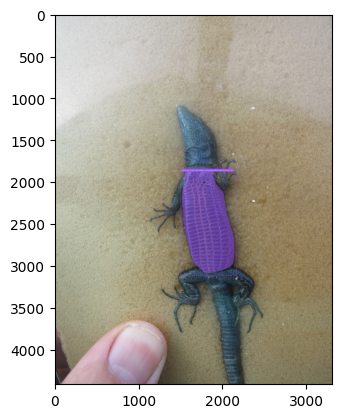

In [7]:
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

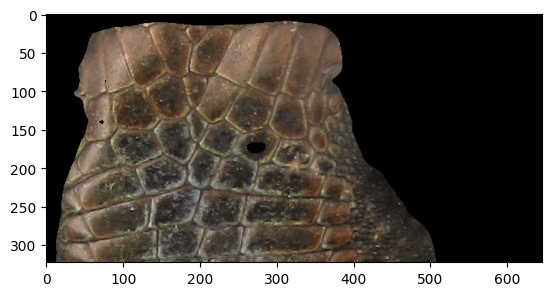

In [8]:
utils.crop_and_display_image(image=image, mask=detections.mask[0])